In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nse-dataset-analyctis/NSE-TATAGLOBAL11.csv


## Importing data & first look

In [2]:
df=pd.read_csv('/kaggle/input/nse-dataset-analyctis/NSE-TATAGLOBAL11.csv',index_col=0)
df.head(n=8)

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914.0,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859.0,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909.0,5248.60


### We can clearly see that the newer observations are on the top. So, we need to reverse the data for our analysis.

In [3]:
# Reversing the rows of the dataframe
df=df.iloc[::-1]
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


In [4]:
df.shape

(1235, 7)

### Our main focus is on predicting the closing value of stock. So, we are going to analyse the "close" column of our dataset.

In [5]:
st=df['Close']

### Train Test Split

In [6]:
train=st.iloc[0:1150]
test=st.iloc[1150:]
print(train.shape," ",test.shape)

(1150,)   (85,)


## Rolling Mean Plot of our time series data

Date
2013-11-05    162.2100
2013-11-06    162.5975
2013-11-07    162.8375
2013-11-08    162.8350
2013-11-11    162.6600
2013-11-12    162.4150
2013-11-13    161.7275
2013-11-14    160.8250
2013-11-18    160.0000
2013-11-19    159.2475
Name: Close, dtype: float64


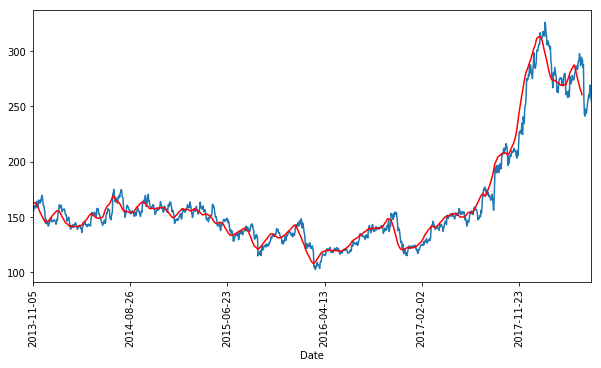

In [7]:
rolling_mean = train.rolling(window=20).mean().dropna()
print(rolling_mean.head(10))
# plot original and transformed dataset
train.plot(figsize=(20,10),linewidth=1.5)
rolling_mean.plot(figsize=(10,5),color='red',linewidth=1.5)
plt.xticks(rotation=90)
plt.show()

## Checking whether the data is seasonal or not

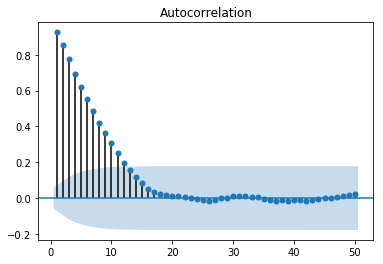

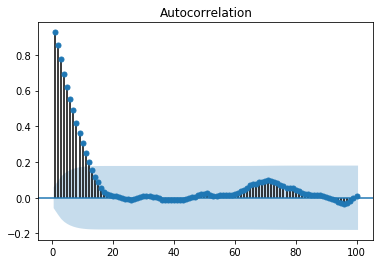

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
st2=train-train.rolling(20).mean()
st2=st2.dropna()

plot_acf(st2,zero=False, lags=50)
plt.show()

plot_acf(st2,zero=False, lags=100)
plt.show()

### As we can see above, there is no repeating pattern in the acf plot. So, we can conclude that our data is non seasonal.

## Test for Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

### Applying the ADF test on train data

In [10]:
adf(train)

ADF Statistic: -0.443513
p-value: 0.902576
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


### Making our data stationary by differencing

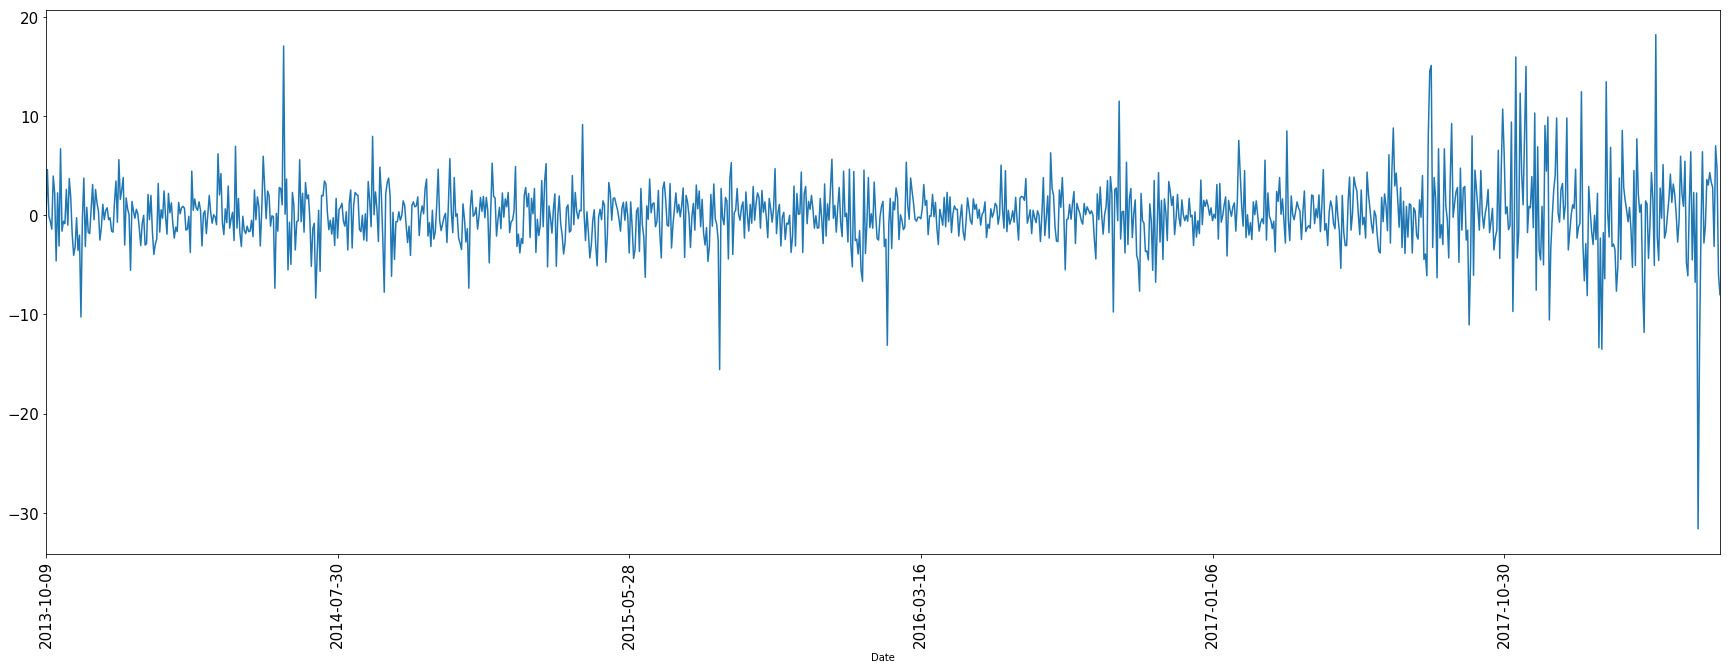

In [11]:
st3= train.diff().dropna()
st3.plot(figsize=(30,10),linewidth=1.5,fontsize=15)
plt.xticks(rotation=90)
plt.show()

### Applying the ADF test on data obtained after first differencing

In [12]:
adf(st3)

ADF Statistic: -33.704402
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Ho - Time Series is Stationary


### First difference has made the data stationary (test statistic sig. less than critical value so we can reject null ho). Also, we can see observe in the above plot that our data is stationary.

## ACF & PACF plots to find the order of ARIMA model

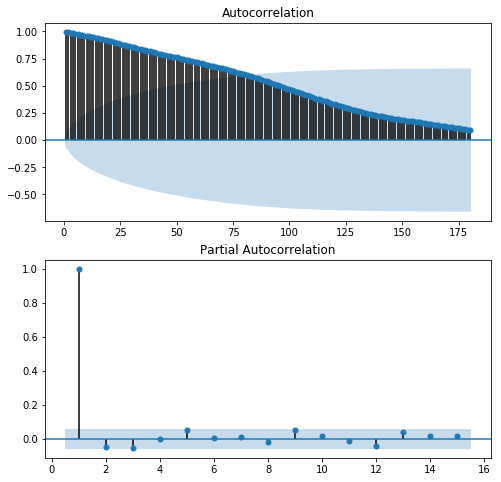

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2)=plt.subplots(2,1, figsize=(8,8))
plot_acf(train, lags=180, zero=False, ax=ax1)
plot_pacf(train, lags=15, zero=False, ax=ax2)
plt.show()

### As we can see above the acf decreases slowly to zero while the pacf cuts off after lag 1 so, the order of ARIMA is (1, 1, 0). We can confirm this using akaike information criterion and bayesian information criterion for various model orders.

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order_aic_bic=[]
for p in range(6):
    for d in range(6):
        for q in range(6):
            model=SARIMAX(train, order=(p,d,q))
            results=model.fit()
            order_aic_bic.append((p,d,q, results.aic, results.bic))
order_df=pd.DataFrame(order_aic_bic, columns=['p','d','q','aic','bic'])

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when 

In [15]:
order_df.sort_values('bic')

,p,d,q,aic,bic
6,0,1,0,6090.111285,6095.157932
42,1,1,0,6092.103274,6102.196569
7,0,1,1,6092.103668,6102.196963
13,0,2,1,6093.894445,6103.985998
8,0,1,2,6093.287609,6108.427551
...,...,...,...,...,...
2,0,0,2,12158.701221,12173.843773
4,0,0,4,12391.297380,12416.534966
71,1,5,5,12598.739585,12634.041704
1,0,0,1,13518.536962,13528.631997


### As we know the model has no meaning when both auto-regressive coeff. (p) and moving average coeff. (q) are 0. So, the best model order is (1,1,0).